# Modelling lithium plating in PyBaMM

This notebook shows how PyBaMM [7] can be used to model both reversible and irreversible lithium plating.

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

You should consider upgrading via the '/home/sokane/PyBaMM/env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


The Doyle-Fuller-Newman model [3] is upgraded with three different lithium plating models. Model 1 contains the reversible lithium plating model of O'Kane et al. [6]. Model 2 contains the same model but with the lithium stripping capability removed, making the plating irreversible. Model 3 contains the updated partially reversible plating of O'Kane et al. [7]. The parameters are taken from Chen et al.'s investigation [2] of an LG M50 cell.

In [2]:
# choose models
model1 = pybamm.lithium_ion.DFN(options={"lithium plating": "reversible"})
model2 = pybamm.lithium_ion.DFN(options={"lithium plating": "irreversible"})
model3 = pybamm.lithium_ion.DFN(options={"lithium plating": "partially reversible"})

# pick parameters
parameter_values = pybamm.ParameterValues("OKane2022")
parameter_values.update({"Ambient temperature [K]": 268.15})
parameter_values.update({"Upper voltage cut-off [V]": 4.21})
#parameter_values.update({"Lithium plating kinetic rate constant [m.s-1]": 1E-9})
parameter_values.update({"Lithium plating transfer coefficient": 0.5})
parameter_values.update({"Dead lithium decay constant [s-1]": 1E-4})

A series of simple fast charging experiments based on those of Ren et al. [8] is defined here. We first initialise the model at 0% SoC by performing a C/20 discharge (see more details on how to initialise a model from a simulation in [this notebook](./initialise-model-with-solution.ipynb)).

In [3]:
# specify experiments
pybamm.citations.register("Ren2018")

experiment_discharge = pybamm.Experiment(
    [
        ("Discharge at C/20 until 2.5 V (10 minute period)",
        "Rest for 1 hour (3 minute period)")
    ]
)

sim_discharge1 = pybamm.Simulation(model1, parameter_values=parameter_values, experiment=experiment_discharge)
sol_discharge1 = sim_discharge1.solve(calc_esoh=False)
model1.set_initial_conditions_from(sol_discharge1, inplace=True)

sim_discharge2 = pybamm.Simulation(model2, parameter_values=parameter_values, experiment=experiment_discharge)
sol_discharge2 = sim_discharge2.solve(calc_esoh=False)
model2.set_initial_conditions_from(sol_discharge2, inplace=True)

sim_discharge3 = pybamm.Simulation(model3, parameter_values=parameter_values, experiment=experiment_discharge)
sol_discharge3 = sim_discharge3.solve(calc_esoh=False)
model3.set_initial_conditions_from(sol_discharge3, inplace=True)

And we can now define the different experiments to charge at different C-rates.

In [4]:
experiment_2C = pybamm.Experiment(
    [
        ("Charge at 2C until 4.2 V",
        "Hold at 4.2 V until C/20",
        "Rest for 1 hour")
    ]
)
experiment_1C = pybamm.Experiment(
    [
        ("Charge at 1C until 4.2 V",
        "Hold at 4.2 V until C/20",
        "Rest for 1 hour")
    ]
)
experiment_Cover2 = pybamm.Experiment(
    [
        ("Charge at C/2 until 4.2 V",
        "Hold at 4.2 V until C/20",
        "Rest for 1 hour")
    ]
)
experiment_Cover4 = pybamm.Experiment(
    [
        ("Charge at C/4 until 4.2 V",
        "Hold at 4.2 V until C/20",
        "Rest for 1 hour")
    ]
)
experiment_Cover8 = pybamm.Experiment(
    [
        ("Charge at C/8 until 4.2 V",
        "Hold at 4.2 V until C/20",
        "Rest for 1 hour")
    ]
)

Solve the reversible plating model first. The default CasADi [1] solver is used here.

In [5]:
sim1_2C = pybamm.Simulation(model1, experiment=experiment_2C, parameter_values=parameter_values)
sim1_2C.solve(calc_esoh=False)
sim1_1C = pybamm.Simulation(model1, experiment=experiment_1C, parameter_values=parameter_values)
sim1_1C.solve(calc_esoh=False)
sim1_Cover2 = pybamm.Simulation(model1, experiment=experiment_Cover2, parameter_values=parameter_values)
sim1_Cover2.solve(calc_esoh=False)
sim1_Cover4 = pybamm.Simulation(model1, experiment=experiment_Cover4, parameter_values=parameter_values)
sim1_Cover4.solve(calc_esoh=False)
sim1_Cover8 = pybamm.Simulation(model1, experiment=experiment_Cover8, parameter_values=parameter_values)
sim1_Cover8.solve(calc_esoh=False)

In [6]:
A = parameter_values.evaluate(model1.param.L_y * model1.param.L_z)
F = parameter_values.evaluate(model1.param.F)
L_n = parameter_values.evaluate(model1.param.n.L)
# Isolate final equilibration phase
sol_2C_rest = sim1_2C.solution.cycles[0].steps[2]
sol_1C_rest = sim1_1C.solution.cycles[0].steps[2]
sol_Cover2_rest = sim1_Cover2.solution.cycles[0].steps[2]
sol_Cover4_rest = sim1_Cover4.solution.cycles[0].steps[2]
sol_Cover8_rest = sim1_Cover8.solution.cycles[0].steps[2]
# Time (hours)
t_2C = sol_2C_rest["Time [s]"].entries-sol_2C_rest["Time [s]"].entries[0]
t_1C = sol_1C_rest["Time [s]"].entries-sol_1C_rest["Time [s]"].entries[0]
t_Cover2 = sol_Cover2_rest["Time [s]"].entries-sol_Cover2_rest["Time [s]"].entries[0]
t_Cover4 = sol_Cover4_rest["Time [s]"].entries-sol_Cover4_rest["Time [s]"].entries[0]
t_Cover8 = sol_Cover8_rest["Time [s]"].entries-sol_Cover8_rest["Time [s]"].entries[0]
# Intercalated capacity (Ah)
Q_main_2C = sol_2C_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_1C = sol_1C_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_Cover2 = sol_Cover2_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_Cover4 = sol_Cover4_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_Cover8 = sol_Cover8_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
# Plated capacity (Ah)
Q_Li_2C = sol_2C_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_1C = sol_1C_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_Cover2 = sol_Cover2_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_Cover4 = sol_Cover4_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_Cover8 = sol_Cover8_rest["Loss of capacity to lithium plating [A.h]"].entries
# Voltage (V)
V_2C = sol_2C_rest["Terminal voltage [V]"].entries
V_1C = sol_1C_rest["Terminal voltage [V]"].entries
V_Cover2 = sol_Cover2_rest["Terminal voltage [V]"].entries
V_Cover4 = sol_Cover4_rest["Terminal voltage [V]"].entries
V_Cover8 = sol_Cover8_rest["Terminal voltage [V]"].entries
# Dimensionless current components
j_2C = sol_2C_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_2C = sol_2C_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_2C = sol_2C_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_1C = sol_1C_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_1C = sol_1C_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_1C = sol_1C_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_Cover2 = sol_Cover2_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_Cover2 = sol_Cover2_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_Cover2 = sol_Cover2_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_Cover4 = sol_Cover4_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_Cover4 = sol_Cover4_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_Cover4 = sol_Cover4_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_Cover8 = sol_Cover8_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_Cover8 = sol_Cover8_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_Cover8 = sol_Cover8_rest["Sum of x-averaged negative electrode interfacial current densities"].entries

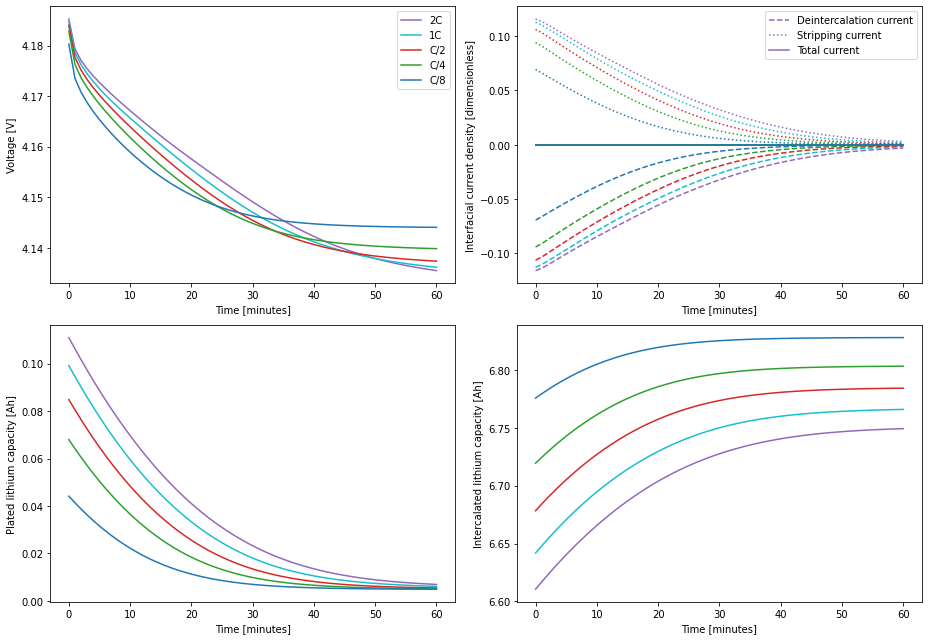

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(13,9))
axs[0,0].plot(t_2C/60, V_2C, color='tab:purple', linestyle='solid')
axs[0,0].plot(t_1C/60, V_1C, color='tab:cyan', linestyle='solid')
axs[0,0].plot(t_Cover2/60, V_Cover2, color='tab:red', linestyle='solid')
axs[0,0].plot(t_Cover4/60, V_Cover4, color='tab:green', linestyle='solid')
axs[0,0].plot(t_Cover8/60, V_Cover8, color='tab:blue', linestyle='solid')
axs[0,0].set_xlabel("Time [minutes]")
axs[0,0].set_ylabel("Voltage [V]")
axs[0,0].legend(('2C','1C','C/2','C/4','C/8'))
axs[0,1].plot(t_2C/60, j_2C, color='tab:purple', linestyle='dashed')
axs[0,1].plot(t_2C/60, j_sr_2C, color='tab:purple', linestyle='dotted')
axs[0,1].plot(t_2C/60, j_sum_2C, color='tab:purple', linestyle='solid')
axs[0,1].plot(t_1C/60, j_1C, color='tab:cyan', linestyle='dashed')
axs[0,1].plot(t_1C/60, j_sr_1C, color='tab:cyan', linestyle='dotted')
axs[0,1].plot(t_1C/60, j_sum_1C, color='tab:cyan', linestyle='solid')
axs[0,1].plot(t_Cover2/60, j_Cover2, color='tab:red', linestyle='dashed')
axs[0,1].plot(t_Cover2/60, j_sr_Cover2, color='tab:red', linestyle='dotted')
axs[0,1].plot(t_Cover2/60, j_sum_Cover2, color='tab:red', linestyle='solid')
axs[0,1].plot(t_Cover4/60, j_Cover4, color='tab:green', linestyle='dashed')
axs[0,1].plot(t_Cover4/60, j_sr_Cover4, color='tab:green', linestyle='dotted')
axs[0,1].plot(t_Cover4/60, j_sum_Cover4, color='tab:green', linestyle='solid')
axs[0,1].plot(t_Cover8/60, j_Cover8, color='tab:blue', linestyle='dashed')
axs[0,1].plot(t_Cover8/60, j_sr_Cover8, color='tab:blue', linestyle='dotted')
axs[0,1].plot(t_Cover8/60, j_sum_Cover8, color='tab:blue', linestyle='solid')
axs[0,1].set_xlabel("Time [minutes]")
axs[0,1].set_ylabel("Interfacial current density [dimensionless]")
axs[0,1].legend(('Deintercalation current','Stripping current','Total current'))
axs[1,0].plot(t_2C/60, Q_Li_2C, color='tab:purple', linestyle='solid')
axs[1,0].plot(t_1C/60, Q_Li_1C, color='tab:cyan', linestyle='solid')
axs[1,0].plot(t_Cover2/60, Q_Li_Cover2, color='tab:red', linestyle='solid')
axs[1,0].plot(t_Cover4/60, Q_Li_Cover4, color='tab:green', linestyle='solid')
axs[1,0].plot(t_Cover8/60, Q_Li_Cover8, color='tab:blue', linestyle='solid')
axs[1,0].set_xlabel("Time [minutes]")
axs[1,0].set_ylabel("Plated lithium capacity [Ah]")
axs[1,1].plot(t_2C/60, Q_main_2C, color='tab:purple', linestyle='solid')
axs[1,1].plot(t_1C/60, Q_main_1C, color='tab:cyan', linestyle='solid')
axs[1,1].plot(t_Cover2/60, Q_main_Cover2, color='tab:red', linestyle='solid')
axs[1,1].plot(t_Cover4/60, Q_main_Cover4, color='tab:green', linestyle='solid')
axs[1,1].plot(t_Cover8/60, Q_main_Cover8, color='tab:blue', linestyle='solid')
axs[1,1].set_xlabel("Time [minutes]")
axs[1,1].set_ylabel("Intercalated lithium capacity [Ah]")
plt.tight_layout()
plt.show()

The results show both similarities and differences with those of Ren et al. [8]. Notably, unlike Ren et al., this model uses equations [6] that result in a small but finite amount of plated lithium being present in the steady state.

Now solve the irreversible plating model and see how it compares.

In [8]:
sim2_2C = pybamm.Simulation(model2, experiment=experiment_2C, parameter_values=parameter_values)
sim2_2C.solve(calc_esoh=False)
sim2_1C = pybamm.Simulation(model2, experiment=experiment_1C, parameter_values=parameter_values)
sim2_1C.solve(calc_esoh=False)
sim2_Cover2 = pybamm.Simulation(model2, experiment=experiment_Cover2, parameter_values=parameter_values)
sim2_Cover2.solve(calc_esoh=False)
sim2_Cover4 = pybamm.Simulation(model2, experiment=experiment_Cover4, parameter_values=parameter_values)
sim2_Cover4.solve(calc_esoh=False)
sim2_Cover8 = pybamm.Simulation(model2, experiment=experiment_Cover8, parameter_values=parameter_values)
sim2_Cover8.solve(calc_esoh=False)

In [9]:
# WARNING: RUNNING THIS CELL WILL OVERWRITE PREVIOUS VARIABLES (but not the raw solution data)
A = parameter_values.evaluate(model2.param.L_y * model2.param.L_z)
F = parameter_values.evaluate(model2.param.F)
L_n = parameter_values.evaluate(model2.param.n.L)
# Isolate final equilibration phase
sol_2C_rest = sim2_2C.solution.cycles[0].steps[2]
sol_1C_rest = sim2_1C.solution.cycles[0].steps[2]
sol_Cover2_rest = sim2_Cover2.solution.cycles[0].steps[2]
sol_Cover4_rest = sim2_Cover4.solution.cycles[0].steps[2]
sol_Cover8_rest = sim2_Cover8.solution.cycles[0].steps[2]
# Time (hours)
t_2C = sol_2C_rest["Time [s]"].entries-sol_2C_rest["Time [s]"].entries[0]
t_1C = sol_1C_rest["Time [s]"].entries-sol_1C_rest["Time [s]"].entries[0]
t_Cover2 = sol_Cover2_rest["Time [s]"].entries-sol_Cover2_rest["Time [s]"].entries[0]
t_Cover4 = sol_Cover4_rest["Time [s]"].entries-sol_Cover4_rest["Time [s]"].entries[0]
t_Cover8 = sol_Cover8_rest["Time [s]"].entries-sol_Cover8_rest["Time [s]"].entries[0]
# Intercalated capacity (Ah)
Q_main_2C = sol_2C_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_1C = sol_1C_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_Cover2 = sol_Cover2_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_Cover4 = sol_Cover4_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_Cover8 = sol_Cover8_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
# Plated capacity (Ah)
Q_Li_2C = sol_2C_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_1C = sol_1C_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_Cover2 = sol_Cover2_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_Cover4 = sol_Cover4_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_Cover8 = sol_Cover8_rest["Loss of capacity to lithium plating [A.h]"].entries
# Voltage (V)
V_2C = sol_2C_rest["Terminal voltage [V]"].entries
V_1C = sol_1C_rest["Terminal voltage [V]"].entries
V_Cover2 = sol_Cover2_rest["Terminal voltage [V]"].entries
V_Cover4 = sol_Cover4_rest["Terminal voltage [V]"].entries
V_Cover8 = sol_Cover8_rest["Terminal voltage [V]"].entries
# Dimensionless current components
j_2C = sol_2C_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_2C = sol_2C_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_2C = sol_2C_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_1C = sol_1C_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_1C = sol_1C_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_1C = sol_1C_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_Cover2 = sol_Cover2_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_Cover2 = sol_Cover2_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_Cover2 = sol_Cover2_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_Cover4 = sol_Cover4_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_Cover4 = sol_Cover4_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_Cover4 = sol_Cover4_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_Cover8 = sol_Cover8_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_Cover8 = sol_Cover8_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_Cover8 = sol_Cover8_rest["Sum of x-averaged negative electrode interfacial current densities"].entries

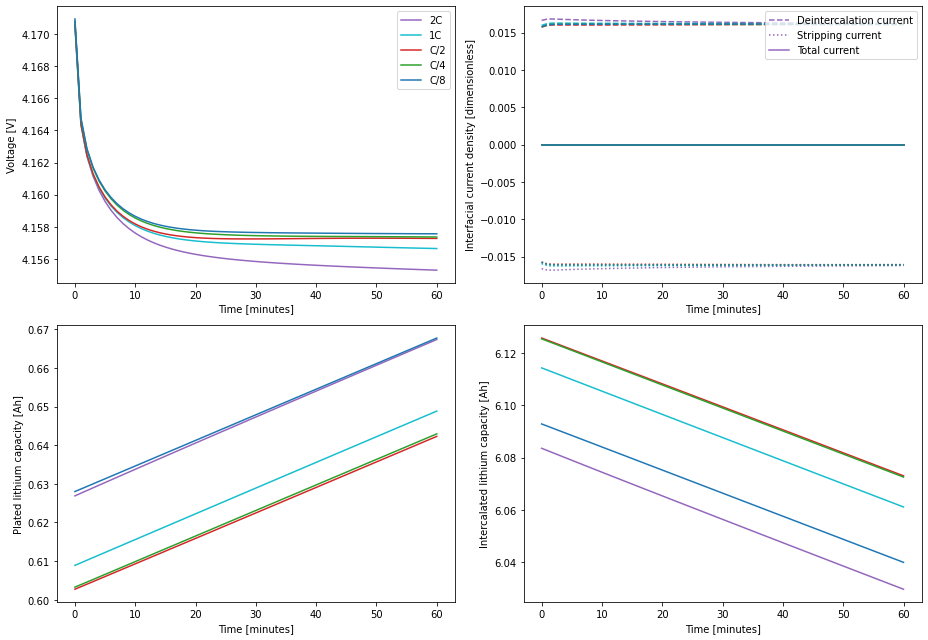

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(13,9))
axs[0,0].plot(t_2C/60, V_2C, color='tab:purple', linestyle='solid')
axs[0,0].plot(t_1C/60, V_1C, color='tab:cyan', linestyle='solid')
axs[0,0].plot(t_Cover2/60, V_Cover2, color='tab:red', linestyle='solid')
axs[0,0].plot(t_Cover4/60, V_Cover4, color='tab:green', linestyle='solid')
axs[0,0].plot(t_Cover8/60, V_Cover8, color='tab:blue', linestyle='solid')
axs[0,0].set_xlabel("Time [minutes]")
axs[0,0].set_ylabel("Voltage [V]")
axs[0,0].legend(('2C','1C','C/2','C/4','C/8'))
axs[0,1].plot(t_2C/60, j_2C, color='tab:purple', linestyle='dashed')
axs[0,1].plot(t_2C/60, j_sr_2C, color='tab:purple', linestyle='dotted')
axs[0,1].plot(t_2C/60, j_sum_2C, color='tab:purple', linestyle='solid')
axs[0,1].plot(t_1C/60, j_1C, color='tab:cyan', linestyle='dashed')
axs[0,1].plot(t_1C/60, j_sr_1C, color='tab:cyan', linestyle='dotted')
axs[0,1].plot(t_1C/60, j_sum_1C, color='tab:cyan', linestyle='solid')
axs[0,1].plot(t_Cover2/60, j_Cover2, color='tab:red', linestyle='dashed')
axs[0,1].plot(t_Cover2/60, j_sr_Cover2, color='tab:red', linestyle='dotted')
axs[0,1].plot(t_Cover2/60, j_sum_Cover2, color='tab:red', linestyle='solid')
axs[0,1].plot(t_Cover4/60, j_Cover4, color='tab:green', linestyle='dashed')
axs[0,1].plot(t_Cover4/60, j_sr_Cover4, color='tab:green', linestyle='dotted')
axs[0,1].plot(t_Cover4/60, j_sum_Cover4, color='tab:green', linestyle='solid')
axs[0,1].plot(t_Cover8/60, j_Cover8, color='tab:blue', linestyle='dashed')
axs[0,1].plot(t_Cover8/60, j_sr_Cover8, color='tab:blue', linestyle='dotted')
axs[0,1].plot(t_Cover8/60, j_sum_Cover8, color='tab:blue', linestyle='solid')
axs[0,1].set_xlabel("Time [minutes]")
axs[0,1].set_ylabel("Interfacial current density [dimensionless]")
axs[0,1].legend(('Deintercalation current','Stripping current','Total current'))
axs[1,0].plot(t_2C/60, Q_Li_2C, color='tab:purple', linestyle='solid')
axs[1,0].plot(t_1C/60, Q_Li_1C, color='tab:cyan', linestyle='solid')
axs[1,0].plot(t_Cover2/60, Q_Li_Cover2, color='tab:red', linestyle='solid')
axs[1,0].plot(t_Cover4/60, Q_Li_Cover4, color='tab:green', linestyle='solid')
axs[1,0].plot(t_Cover8/60, Q_Li_Cover8, color='tab:blue', linestyle='solid')
axs[1,0].set_xlabel("Time [minutes]")
axs[1,0].set_ylabel("Plated lithium capacity [Ah]")
axs[1,1].plot(t_2C/60, Q_main_2C, color='tab:purple', linestyle='solid')
axs[1,1].plot(t_1C/60, Q_main_1C, color='tab:cyan', linestyle='solid')
axs[1,1].plot(t_Cover2/60, Q_main_Cover2, color='tab:red', linestyle='solid')
axs[1,1].plot(t_Cover4/60, Q_main_Cover4, color='tab:green', linestyle='solid')
axs[1,1].plot(t_Cover8/60, Q_main_Cover8, color='tab:blue', linestyle='solid')
axs[1,1].set_xlabel("Time [minutes]")
axs[1,1].set_ylabel("Intercalated lithium capacity [Ah]")
plt.tight_layout()
plt.show()

Unlike in the reversible case, there is no steady state and the capacity degrades quickly. The lithium inventory decreases by around 40 mAh in just an hour, which is unrealistic. The low temperature fast charge simulations are run one more time, with the partially reversible plating model.

In [11]:
sim3_2C = pybamm.Simulation(model3, experiment=experiment_2C, parameter_values=parameter_values)
sim3_2C.solve(calc_esoh=False)
sim3_1C = pybamm.Simulation(model3, experiment=experiment_1C, parameter_values=parameter_values)
sim3_1C.solve(calc_esoh=False)
sim3_Cover2 = pybamm.Simulation(model3, experiment=experiment_Cover2, parameter_values=parameter_values)
sim3_Cover2.solve(calc_esoh=False)
sim3_Cover4 = pybamm.Simulation(model3, experiment=experiment_Cover4, parameter_values=parameter_values)
sim3_Cover4.solve(calc_esoh=False)
sim3_Cover8 = pybamm.Simulation(model3, experiment=experiment_Cover8, parameter_values=parameter_values)
sim3_Cover8.solve(calc_esoh=False)

In [12]:
# WARNING: RUNNING THIS CELL WILL OVERWRITE PREVIOUS VARIABLES (but not the raw solution data)
A = parameter_values.evaluate(model3.param.L_y * model2.param.L_z)
F = parameter_values.evaluate(model3.param.F)
L_n = parameter_values.evaluate(model3.param.n.L)
# Isolate final equilibration phase
sol_2C_rest = sim3_2C.solution.cycles[0].steps[2]
sol_1C_rest = sim3_1C.solution.cycles[0].steps[2]
sol_Cover2_rest = sim3_Cover2.solution.cycles[0].steps[2]
sol_Cover4_rest = sim3_Cover4.solution.cycles[0].steps[2]
sol_Cover8_rest = sim3_Cover8.solution.cycles[0].steps[2]
# Time (hours)
t_2C = sol_2C_rest["Time [s]"].entries-sol_2C_rest["Time [s]"].entries[0]
t_1C = sol_1C_rest["Time [s]"].entries-sol_1C_rest["Time [s]"].entries[0]
t_Cover2 = sol_Cover2_rest["Time [s]"].entries-sol_Cover2_rest["Time [s]"].entries[0]
t_Cover4 = sol_Cover4_rest["Time [s]"].entries-sol_Cover4_rest["Time [s]"].entries[0]
t_Cover8 = sol_Cover8_rest["Time [s]"].entries-sol_Cover8_rest["Time [s]"].entries[0]
# Intercalated capacity (Ah)
Q_main_2C = sol_2C_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_1C = sol_1C_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_Cover2 = sol_Cover2_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_Cover4 = sol_Cover4_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
Q_main_Cover8 = sol_Cover8_rest["Negative electrode volume-averaged concentration [mol.m-3]"].entries * F * A * L_n / 3600
# Plated capacity (Ah)
Q_Li_2C = sol_2C_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_1C = sol_1C_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_Cover2 = sol_Cover2_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_Cover4 = sol_Cover4_rest["Loss of capacity to lithium plating [A.h]"].entries
Q_Li_Cover8 = sol_Cover8_rest["Loss of capacity to lithium plating [A.h]"].entries
# Voltage (V)
V_2C = sol_2C_rest["Terminal voltage [V]"].entries
V_1C = sol_1C_rest["Terminal voltage [V]"].entries
V_Cover2 = sol_Cover2_rest["Terminal voltage [V]"].entries
V_Cover4 = sol_Cover4_rest["Terminal voltage [V]"].entries
V_Cover8 = sol_Cover8_rest["Terminal voltage [V]"].entries
# Dimensionless current components
j_2C = sol_2C_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_2C = sol_2C_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_2C = sol_2C_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_1C = sol_1C_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_1C = sol_1C_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_1C = sol_1C_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_Cover2 = sol_Cover2_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_Cover2 = sol_Cover2_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_Cover2 = sol_Cover2_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_Cover4 = sol_Cover4_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_Cover4 = sol_Cover4_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_Cover4 = sol_Cover4_rest["Sum of x-averaged negative electrode interfacial current densities"].entries
j_Cover8 = sol_Cover8_rest["X-averaged negative electrode interfacial current density"].entries
j_sr_Cover8 = sol_Cover8_rest["X-averaged lithium plating interfacial current density"].entries
j_sum_Cover8 = sol_Cover8_rest["Sum of x-averaged negative electrode interfacial current densities"].entries

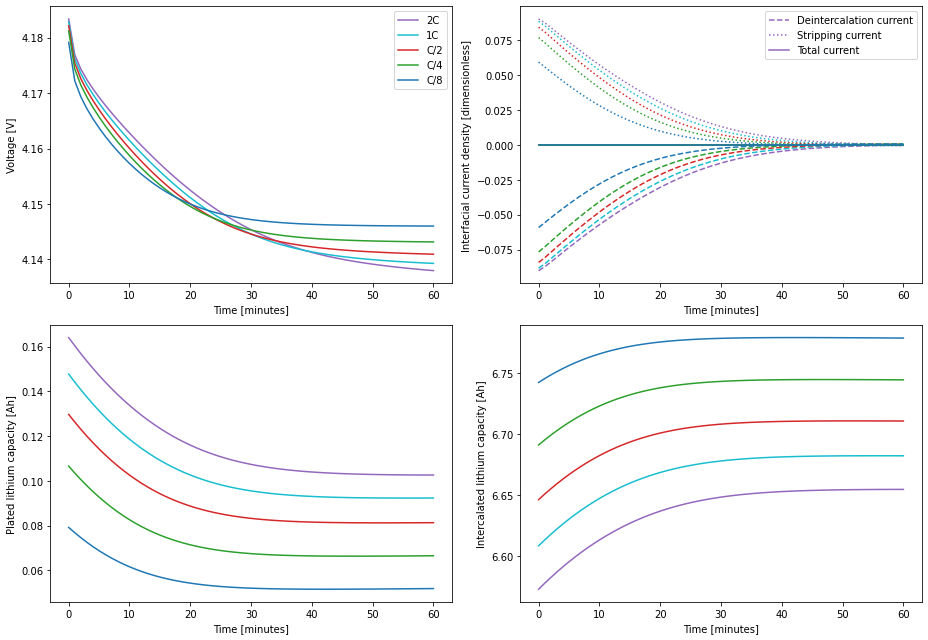

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(13,9))
axs[0,0].plot(t_2C/60, V_2C, color='tab:purple', linestyle='solid')
axs[0,0].plot(t_1C/60, V_1C, color='tab:cyan', linestyle='solid')
axs[0,0].plot(t_Cover2/60, V_Cover2, color='tab:red', linestyle='solid')
axs[0,0].plot(t_Cover4/60, V_Cover4, color='tab:green', linestyle='solid')
axs[0,0].plot(t_Cover8/60, V_Cover8, color='tab:blue', linestyle='solid')
axs[0,0].set_xlabel("Time [minutes]")
axs[0,0].set_ylabel("Voltage [V]")
axs[0,0].legend(('2C','1C','C/2','C/4','C/8'))
axs[0,1].plot(t_2C/60, j_2C, color='tab:purple', linestyle='dashed')
axs[0,1].plot(t_2C/60, j_sr_2C, color='tab:purple', linestyle='dotted')
axs[0,1].plot(t_2C/60, j_sum_2C, color='tab:purple', linestyle='solid')
axs[0,1].plot(t_1C/60, j_1C, color='tab:cyan', linestyle='dashed')
axs[0,1].plot(t_1C/60, j_sr_1C, color='tab:cyan', linestyle='dotted')
axs[0,1].plot(t_1C/60, j_sum_1C, color='tab:cyan', linestyle='solid')
axs[0,1].plot(t_Cover2/60, j_Cover2, color='tab:red', linestyle='dashed')
axs[0,1].plot(t_Cover2/60, j_sr_Cover2, color='tab:red', linestyle='dotted')
axs[0,1].plot(t_Cover2/60, j_sum_Cover2, color='tab:red', linestyle='solid')
axs[0,1].plot(t_Cover4/60, j_Cover4, color='tab:green', linestyle='dashed')
axs[0,1].plot(t_Cover4/60, j_sr_Cover4, color='tab:green', linestyle='dotted')
axs[0,1].plot(t_Cover4/60, j_sum_Cover4, color='tab:green', linestyle='solid')
axs[0,1].plot(t_Cover8/60, j_Cover8, color='tab:blue', linestyle='dashed')
axs[0,1].plot(t_Cover8/60, j_sr_Cover8, color='tab:blue', linestyle='dotted')
axs[0,1].plot(t_Cover8/60, j_sum_Cover8, color='tab:blue', linestyle='solid')
axs[0,1].set_xlabel("Time [minutes]")
axs[0,1].set_ylabel("Interfacial current density [dimensionless]")
axs[0,1].legend(('Deintercalation current','Stripping current','Total current'))
axs[1,0].plot(t_2C/60, Q_Li_2C, color='tab:purple', linestyle='solid')
axs[1,0].plot(t_1C/60, Q_Li_1C, color='tab:cyan', linestyle='solid')
axs[1,0].plot(t_Cover2/60, Q_Li_Cover2, color='tab:red', linestyle='solid')
axs[1,0].plot(t_Cover4/60, Q_Li_Cover4, color='tab:green', linestyle='solid')
axs[1,0].plot(t_Cover8/60, Q_Li_Cover8, color='tab:blue', linestyle='solid')
axs[1,0].set_xlabel("Time [minutes]")
axs[1,0].set_ylabel("Plated lithium capacity [Ah]")
axs[1,1].plot(t_2C/60, Q_main_2C, color='tab:purple', linestyle='solid')
axs[1,1].plot(t_1C/60, Q_main_1C, color='tab:cyan', linestyle='solid')
axs[1,1].plot(t_Cover2/60, Q_main_Cover2, color='tab:red', linestyle='solid')
axs[1,1].plot(t_Cover4/60, Q_main_Cover4, color='tab:green', linestyle='solid')
axs[1,1].plot(t_Cover8/60, Q_main_Cover8, color='tab:blue', linestyle='solid')
axs[1,1].set_xlabel("Time [minutes]")
axs[1,1].set_ylabel("Intercalated lithium capacity [Ah]")
plt.tight_layout()
plt.show()

The partially reversible plating model has features of both the reversible and irreversible models, which is reflected in the results. The plated lithium capacity decreases with time as lithium is reversibly stripped, but the final plated lithium capacity now depends on charge rate, indicating that some lithium was irreversibly plated during charge.

# References

In [14]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of